In [136]:
def batched_invert_matrix(A):
    first, second = int(A.shape[0]), int(A.shape[1])
    M = A.reshape(-1, 9)
    a, b, c, d, e, f, g, h, i = [x.squeeze(-1) for x in torch.split(M, [1 for _ in range(9)], dim=-1)]
    coefficient = a * (e * i - f * h) - b * (d * i - f * g) + c * (d * h - e * g)
    entries = torch.stack([e * i - f * h, c * h - b * i, b * f - c * e, f * g - d * i,
                           a * i - c * g, c * d - a * f, d * h - e * g, b * g - a * h, a * e - b * d], dim=1)
    entries /= coefficient[:, None]
    entries = entries.reshape(-1, 3, 3)
    return entries.unflatten(0, [first, second])

In [128]:
def batched_pseudo_inv_3x3(matrices, tol=1e-9):
    """
    Compute the batched pseudo-inverse of a set of 3x3 matrices using analytical expressions.
    
    Parameters:
        matrices (Tensor): A batch of 3x3 matrices with shape (batch_size, 3, 3)
        tol (float): Tolerance for treating eigenvalues as zero

    Returns:
        Tensor: The batched pseudo-inverse with shape (batch_size, 3, 3)
    """
    first, second = matrices.shape[0], matrices.shape[1]
    matrices = matrices.reshape(-1, 3, 3)
    
    # Calculate determinants for 3x3 matrices in the batch
    det = matrices[:, 0, 0] * (matrices[:, 1, 1] * matrices[:, 2, 2] - matrices[:, 1, 2] * matrices[:, 2, 1]) - \
          matrices[:, 0, 1] * (matrices[:, 1, 0] * matrices[:, 2, 2] - matrices[:, 1, 2] * matrices[:, 2, 0]) + \
          matrices[:, 0, 2] * (matrices[:, 1, 0] * matrices[:, 2, 1] - matrices[:, 1, 1] * matrices[:, 2, 0])
    
    # Create an empty tensor to store the batched pseudo-inverse
    batch_size = matrices.shape[0]
    pseudo_inv = torch.zeros((batch_size, 3, 3), device=matrices.device, dtype=matrices.dtype)
    
    # Compute adjoint of the matrix for all batches
    adjoint = torch.zeros_like(matrices)
    adjoint[:, 0, 0] = matrices[:, 1, 1] * matrices[:, 2, 2] - matrices[:, 1, 2] * matrices[:, 2, 1]
    adjoint[:, 0, 1] = matrices[:, 0, 2] * matrices[:, 2, 1] - matrices[:, 0, 1] * matrices[:, 2, 2]
    adjoint[:, 0, 2] = matrices[:, 0, 1] * matrices[:, 1, 2] - matrices[:, 0, 2] * matrices[:, 1, 1]
    adjoint[:, 1, 0] = matrices[:, 1, 2] * matrices[:, 2, 0] - matrices[:, 1, 0] * matrices[:, 2, 2]
    adjoint[:, 1, 1] = matrices[:, 0, 0] * matrices[:, 2, 2] - matrices[:, 0, 2] * matrices[:, 2, 0]
    adjoint[:, 1, 2] = matrices[:, 0, 2] * matrices[:, 1, 0] - matrices[:, 0, 0] * matrices[:, 1, 2]
    adjoint[:, 2, 0] = matrices[:, 1, 0] * matrices[:, 2, 1] - matrices[:, 1, 1] * matrices[:, 2, 0]
    adjoint[:, 2, 1] = matrices[:, 0, 1] * matrices[:, 2, 0] - matrices[:, 0, 0] * matrices[:, 2, 1]
    adjoint[:, 2, 2] = matrices[:, 0, 0] * matrices[:, 1, 1] - matrices[:, 0, 1] * matrices[:, 1, 0]

    # Compute the pseudo-inverse using the formula: adjoint / determinant
    det_inv = 1.0 / det
    det_inv *= (torch.abs(det) >= tol)  # Handle singular matrices by setting their inverse determinant to zero
    pseudo_inv = adjoint * det_inv.view(-1, 1, 1)
    
    return pseudo_inv.unflatten(0, [first, second])

In [146]:
M= torch.randn(5, 10, 3, 3)
M[:, :, :, 0] *= 0
batched_pseudo_inv_3x3(M),  torch.linalg.pinv(M), batched_invert_matrix(M)

(tensor[5, 10, 3, 3] n=450 NaN!,
 tensor[5, 10, 3, 3] n=450 x∈[-36.988, 27.283] μ=0.016 σ=2.585,
 tensor[5, 10, 3, 3] n=450 +Inf! -Inf! NaN!)

In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import glob
from utils.datasets.RawStreamData import RawStreamDS
from utils.functions_SX import get_ideal_basis, print_solution
import torch
import numpy as np

from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, ConcatDataset
from models.indexer_model import ToroIndexer

import lovely_tensors as lt

lt.monkey_patch()

import os

cwd = os.getcwd()

streams_path = cwd+"/../data/lyso_12p4kev_1khz_150mm_run000026"
# streams_path = cwd+"/../data/performance_test"
mylist = glob.glob(streams_path + '/*.stream', recursive=True)
path = mylist[0]
print("Stream file to be used", path)

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print("Using device ", device)

Stream file to be used /Users/lfbarba/GitHub/toro-indexer-for-serial-crystallography/notebooks/../data/lyso_12p4kev_1khz_150mm_run000026/Lyso_12p4keV_1kHz_150mm_run000026_data_000001.th6.snr4.0.mpixco1.stream
Using device  cpu


In [57]:
spot_sequence_length=100

# # performing params
lattice_size = 50000
angle_resolution = 500
num_top_solutions = 500

# fast params
lattice_size = 25000
angle_resolution = 150
num_top_solutions = 200

# # super fast params
# lattice_size = 20000
# angle_resolution = 100
# num_top_solutions = 50

im = ToroIndexer(
    lattice_size=lattice_size,
    num_iterations=5,
    error_precision=0.0012,
    filter_precision=0.00075,
    filter_min_num_spots=6
).to(device)

mds = RawStreamDS(path, spot_sequence_length, no_padding=True)

Creating DS from  /Users/lfbarba/GitHub/toro-indexer-for-serial-crystallography/notebooks/../data/lyso_12p4kev_1khz_150mm_run000026/Lyso_12p4keV_1kHz_150mm_run000026_data_000001.th6.snr4.0.mpixco1.stream


In [63]:
import random
# We load the indices produded by the stream_file_indexer.py
# indices = np.load("../solution_indices.npy")
# idx = indices[random.randint(0, len(indices) - 1)]
# idx = 6471
# mds_idx = random.randint(0, len(mds) - 1)
cell_parameters = mds.instances[mds_idx]['initial_cell']
initial_cell = get_ideal_basis(cell_parameters)

peaks, _ = mds[mds_idx]

solution_successes, solution_triples, solution_masks, solution_errors, solution_penalization = im(
        peaks.repeat(1, 1, 1).to(device),
        initial_cell.to(device),
        min_num_spots=6,
        angle_resolution=angle_resolution,
        num_top_solutions=num_top_solutions
    )


with torch.no_grad():
    for batch, (success_crystals, matrix_crystals, peaks_indices_crystals, error_crystals, penalization_crystals) in enumerate(zip(
            solution_successes, solution_triples, solution_masks, solution_errors, solution_penalization
    )):
        print("Num crystals ", len(success_crystals), success_crystals)
        idx_crystal = 0
        for success, best_triple, solution_mask, claimed_error, penalization in zip(success_crystals, matrix_crystals, peaks_indices_crystals, error_crystals, penalization_crystals):
            print("Success ", success)
            rot_data = im.solution_sources[batch][idx_crystal] @ best_triple.T
            targets = torch.round(rot_data)
            back_peaks = targets @ torch.inverse(best_triple).T

            print(torch.sum(solution_mask).item(), "spots")

            print("error", claimed_error.p, "penalization", penalization.p)

            print("length of found basis vectors ", best_triple.norm(dim=-1).p)
            print("ideal length of vectors ", initial_cell.norm(dim=-1).p)
            
            print_solution(best_triple, mds_idx, mds, initial_cell)
            
            best_hkl = torch.round(im.solution_sources[batch][idx_crystal][solution_mask] @ best_triple.T)
#             print(best_hkl.p)
            

# Visualize results from stream_file_indexer.py

In [50]:
indices = np.load("../solution_indices.npy")
bases = np.load("../solution_matrices.npy")

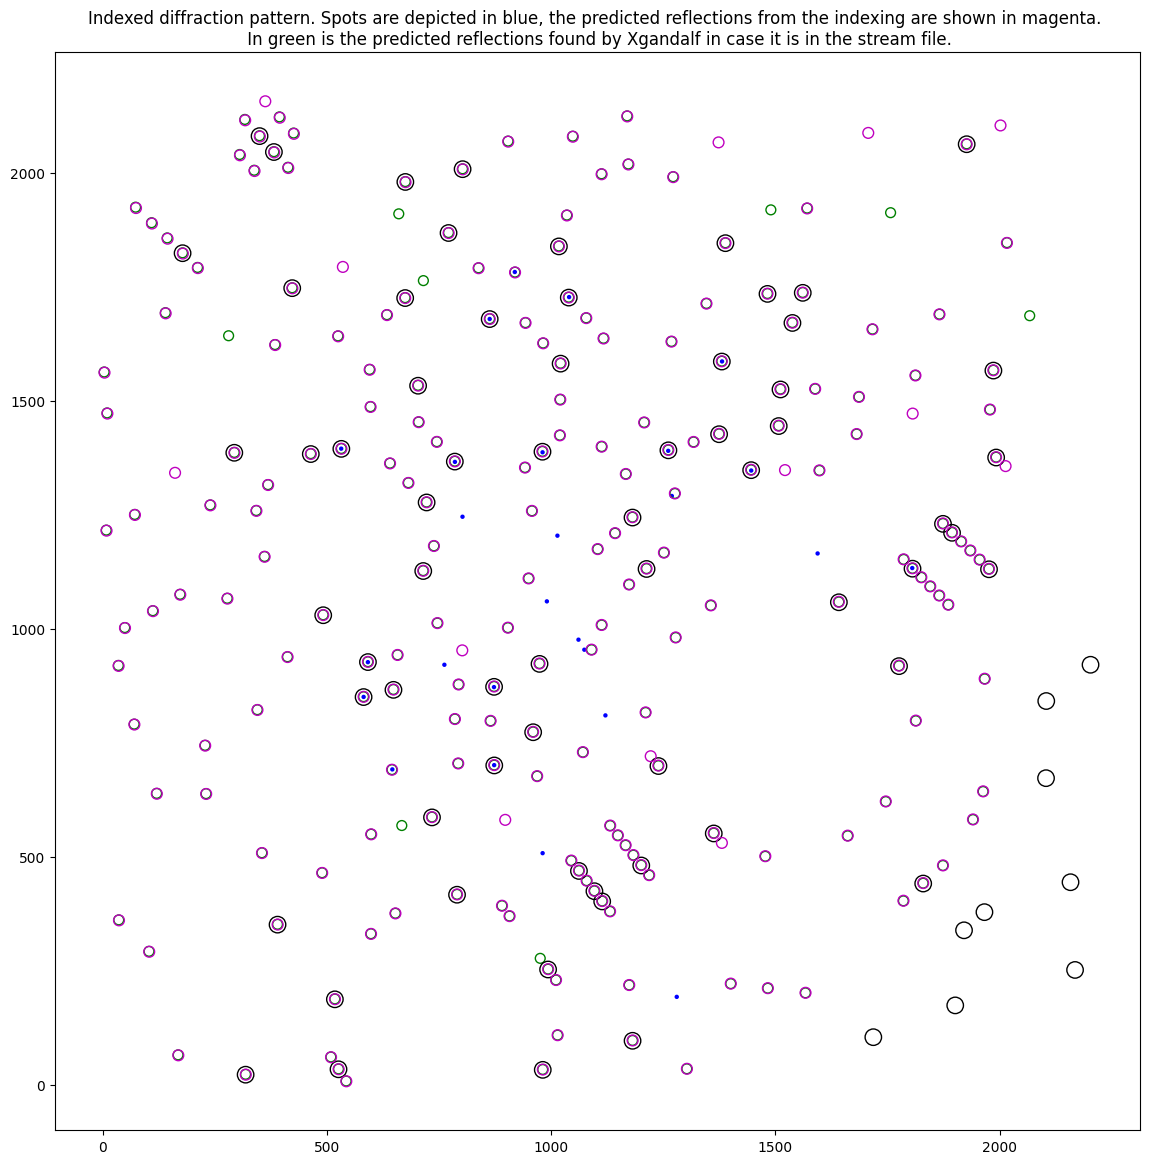

In [62]:
idx = random.randint(0, len(indices) - 1)
mds_idx = indices[idx]
cell_parameters = mds.instances[mds_idx]['initial_cell']
initial_cell = get_ideal_basis(cell_parameters)
print_solution(torch.FloatTensor(bases[idx]), mds_idx, mds, initial_cell)